In [31]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [32]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [33]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = "Gemma2-9b-It")

In [34]:
from langchain_community.document_loaders import YoutubeLoader
loader = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=MDBG2MOp4Go", add_video_info=False
)

In [4]:
try:
    loader = YoutubeLoader.from_youtube_url(
        "https://www.youtube.com/watch?v=MDBG2MOp", add_video_info=False
    )
    response = loader.load()    
    print({"transcript": response[0].page_content})

except Exception as e:
    print({"error": f"Failed to fetch transcript: {str(e)}"})

{'error': 'Failed to fetch transcript: Could not determine the video ID for the URL "https://www.youtube.com/watch?v=MDBG2MOp".'}


In [35]:
response = loader.load()
print(response[0].page_content)

Hello all, my name is Krishna and welcome to my YouTube channel. So guys, welcome to this short crash course on MCP that is model context protocol. In this specific video, we are going to cover many topics. I will be talking about the agenda but everything that has come till now related to MCP I will be covering in this specific video from explaining you the concepts to building MCP servers from scratch to integrate MCP servers from various companies along with that uh we will also try to see that how we can use uh MCP servers in order to build our agentic AI application uh all the specific things we will be covering up uh please make sure that you watch this video till the end. Uh this will be a little long video but uh if you are able to cover almost each and everything in this particular video, you will be able to get a very good understanding about MCP itself. So quickly uh let me go ahead and share my screen. So uh I hope everybody has probably seen this particular um website for 

# Flow

input (Yt video url) => load the transcript (from Yt) => assign a topic to it => assign a specialist of that topic => then give summary of the transcirpt  

In [36]:
from typing import TypedDict
from pydantic import BaseModel

#

class YTState(TypedDict):
    url : str
    transcript : str
    author : str
    author_info : str
    topic : str
    summary : str

class YTSpecialist(BaseModel):
    specialist : str
    specialist_bio : str

In [119]:
def fetchTranscript(state : YTState):
    loader = YoutubeLoader.from_youtube_url(
         state["url"], add_video_info=False
    )
    response = loader.load()
    return {"transcript": response[0].page_content}


def assign_topic(state : YTState):
    prompt = f"""
        You are an AI assistant that identifies the main topic of a transcript.
        Please read the following excerpt from a transcript and determine the **primary topic** being discussed. Be concise and return **only the topic** as a short phrase or sentence, without any additional explanation or formatting.
        Transcript:{state['transcript'][:2000]}  
        In output i want only the topic 
    """
    response = llm.invoke(prompt)
    return {"topic": response.content}

def assign_specialist(state : YTState):

    prompt = f""" You are an AI assistant responsible for assigning the most appropriate real-world expert or well-known specialist to summarize content on a specific topic.

    The expert must be:
    - A real, existing person (no fictional or AI-generated names)
    - Recognized in their field with proven credentials or contributions
    - Relevant to the given topic, either through academic, industry, or public work

    Topic: "{state["topic"]}"
    Return me :
    specialist : Name of person/expert
    specialist_bio : A short background on the expert — who they are and why they're relevant to this topic.

    """
    
    structured_llm = llm.with_structured_output(YTSpecialist)
    response = structured_llm.invoke(prompt)

    # print(response.specialist)
    # print(response.specialist_bio)

    return {
        "author" : response.specialist , 
        "author_info" : response.specialist_bio
    }

def generate_summary(state):

    prompt = f""" 
        
       You are {state["author"]}, widely recognized for: {state["author_info"]}.
       
       Your task is to generate a **detailed, entailed summary** of the following YouTube transcript. The summary should sound like it's written entirely in your **unique voice**—reflecting your tone, perspective, and domain expertise.

        Instructions:
        - Write a **detailed summary** that thoroughly captures all key points, arguments, examples, and conclusions.
        - Every statement must be **entailed**—fully supported by the content in the transcript (no hallucinations or external assumptions).
        - Reflect the **structure and progression** of ideas in the transcript.
        - Use a style and vocabulary that **aligns with how you speak or write** to your audience (e.g., blog, podcast, or talk).
        - Organize the summary in a logical and readable way (bullet points or short paragraphs if needed).

         **Topic**:  
        {state["topic"]}

         **Transcript**:  
        {state["transcript"][:3000]}

        Only return the detailed summary, nothing else.
         """
    
    
    response = llm.invoke(prompt)
    return {
        "topic" : state["topic"],
        "author" : state["author"],
        "author_info" : state["author_info"],
        "summary": response.content
    }

In [120]:
generate_summary(
    {   "topic" : "Gen-ai",
        "transcript" : "Gen-ai is the new era",
        "author" : "Alfred" , 
        "author_info" : "Rsearcher and gen-ai expert"
    }
)

{'topic': 'Gen-ai',
 'author': 'Alfred',
 'author_info': 'Rsearcher and gen-ai expert',
 'summary': 'My esteemed colleagues, \n\n"Gen-ai is the new era" – a bold statement, indeed. And while I wouldn\'t go so far as to declare a complete paradigm shift, it\'s undeniable that generative artificial intelligence is rapidly reshaping our landscape. We stand on the precipice of a fascinating evolution, where machines can not only process information but also create it –  text, images, even code.  This opens up a world of possibilities, but also presents us with significant challenges. We must proceed with both caution and enthusiasm, ensuring responsible development and deployment of this powerful technology. The future is being written, and it\'s incumbent upon us to ensure it\'s a future we can all be proud of. \n\n\n\n\n\n'}

In [125]:
from langgraph.graph import StateGraph , START , END

graph_builder = StateGraph(YTState)

graph_builder.add_node( "fetchTranscript" , fetchTranscript )
graph_builder.add_node( "Assigning_Topic" , assign_topic )
graph_builder.add_node( "Assigning_Specialist" , assign_specialist )
graph_builder.add_node( "Summary Generator",generate_summary)

graph_builder.add_edge(START , "fetchTranscript")
graph_builder.add_edge("fetchTranscript" , "Assigning_Topic")
graph_builder.add_edge("Assigning_Topic" ,  "Assigning_Specialist")
graph_builder.add_edge( "Assigning_Specialist" , "Summary Generator" )
graph_builder.add_edge( "Summary Generator" , END)

graph = graph_builder.compile()

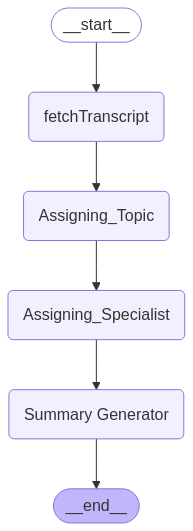

In [126]:
from IPython.display import Image , display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [128]:
input = "https://www.youtube.com/watch?v=MDBG2MOp4Go"
response = graph.invoke({"url" : input})
print(response.keys())
print(response["summary"])

dict_keys(['url', 'transcript', 'author', 'author_info', 'topic', 'summary'])
The Model Context Protocol (MCP), an initiative spearheaded by Anthropic, is gaining traction as a crucial tool for developing agentic AI. Essentially, MCP provides a standardized way to inject and manage context within large language models (LLMs), enabling them to perform more sophisticated and contextually aware tasks. 

This growing ecosystem allows developers to build and integrate MCP servers, acting as intermediaries between LLMs and external applications or services. Imagine this: an LLM-powered chatbot that can seamlessly access your calendar, email, or even specialized databases to provide truly helpful and personalized responses. That's the power of MCP.

There are various implementations and integrations available, including open-source tools and cloud-based solutions.  As research progresses, we'll likely see even more innovative applications of MCP, pushing the boundaries of what's possible with

In [3]:
import sys
sys.path.append('/Users/akashjain/Desktop/AgentVerse/Backend/src/backend')

from LLMs.groqllm  import GroqLLM
from graph.Yt_graph import YT_GRAPH_Builder

/Users/akashjain/Desktop/AgentVerse/AgentVerse/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
usecase = "YT_AI"
obj_llm = GroqLLM()
model = obj_llm.get_llm_model()

In [5]:
graph_builder = YT_GRAPH_Builder(model)
graph = graph_builder.setup_graph(usecase)

In [6]:
response = graph.invoke({"url" : "https://www.youtube.com/watch?v=_3ezSpJw2E8"})


In [7]:
print(response.keys())

dict_keys(['url', 'transcript', 'author', 'author_info', 'topic', 'summary'])


In [8]:
response["summary"]


"Alright, creators, let's break down what's going on with this transcript situation.  \n\nSo, the video in question doesn't have a transcript in English, which is what you initially requested.  The system tells you that no transcripts were found for English. \n\nBut hold on! It gets interesting. The video does have a transcript, but it's in Hindi (generated automatically), and it's marked as translatable. \n\nNow, here's where things get really cool. YouTube lists a bunch of other languages where a transcript *could* be created for this video.  It's like a treasure map of potential translations!  Think of it as an opportunity to make your content accessible to a wider audience.  \n\n\n\n"

In [9]:
response["topic"]


'Transcript availability for a YouTube video \n'

In [10]:
response["transcript"]

'\nCould not retrieve a transcript for the video https://www.youtube.com/watch?v=_3ezSpJw2E8! This is most likely caused by:\n\nNo transcripts were found for any of the requested language codes: [\'en\']\n\nFor this video (_3ezSpJw2E8) transcripts are available in the following languages:\n\n(MANUALLY CREATED)\nNone\n\n(GENERATED)\n - hi ("Hindi (auto-generated)")[TRANSLATABLE]\n\n(TRANSLATION LANGUAGES)\n - ab ("Abkhazian")\n - aa ("Afar")\n - af ("Afrikaans")\n - ak ("Akan")\n - sq ("Albanian")\n - am ("Amharic")\n - ar ("Arabic")\n - hy ("Armenian")\n - as ("Assamese")\n - ay ("Aymara")\n - az ("Azerbaijani")\n - bn ("Bangla")\n - ba ("Bashkir")\n - eu ("Basque")\n - be ("Belarusian")\n - bho ("Bhojpuri")\n - bs ("Bosnian")\n - br ("Breton")\n - bg ("Bulgarian")\n - my ("Burmese")\n - ca ("Catalan")\n - ceb ("Cebuano")\n - zh-Hans ("Chinese (Simplified)")\n - zh-Hant ("Chinese (Traditional)")\n - co ("Corsican")\n - hr ("Croatian")\n - cs ("Czech")\n - da ("Danish")\n - dv ("Divehi"